I used Google Colab, so first of all, I copy the data to the local runtime.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp "/content/drive/MyDrive/ai_finance_projects/prj4/Project#4.xlsx" .

# Project 4 - Predict loan defaults

In [3]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance

## Data Preprocessing

### Load the data

In [4]:
data = pd.read_excel("Project#4.xlsx", sheet_name="creditscore_data")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### Handle Missing Data

In [5]:
data.dropna(subset=['person_emp_length'], inplace=True)
# also "loan_int_rate" has missing data, but later in the notebook I'll remove this variable 
# due to high correlation (0.93) with "loan_grade"

### Handle Categorical Data

In [6]:
data.replace({'cb_person_default_on_file': {'Y': 1, 'N': 0}}, inplace=True)

In [7]:
encoder = OrdinalEncoder()
data[["loan_grade"]] = encoder.fit_transform(data[["loan_grade"]])

In [8]:
encoder = OneHotEncoder()
encoded = encoder.fit_transform(data[["person_home_ownership"]])
feature_names = encoder.get_feature_names_out(input_features=["person_home_ownership"])
encoded_df = pd.DataFrame(encoded.toarray(), columns=feature_names)

encoded_df.index = data.index

data = pd.concat([data, encoded_df], axis=1)
data = data.drop("person_home_ownership", axis=1)

In [9]:
encoder = OneHotEncoder()
encoded = encoder.fit_transform(data[["loan_intent"]])
feature_names = encoder.get_feature_names_out(input_features=["loan_intent"])
encoded_df = pd.DataFrame(encoded.toarray(), columns=feature_names)

encoded_df.index = data.index

data = pd.concat([data, encoded_df], axis=1)
data = data.drop("loan_intent", axis=1)

### Handle Multicollineiarty

<Axes: >

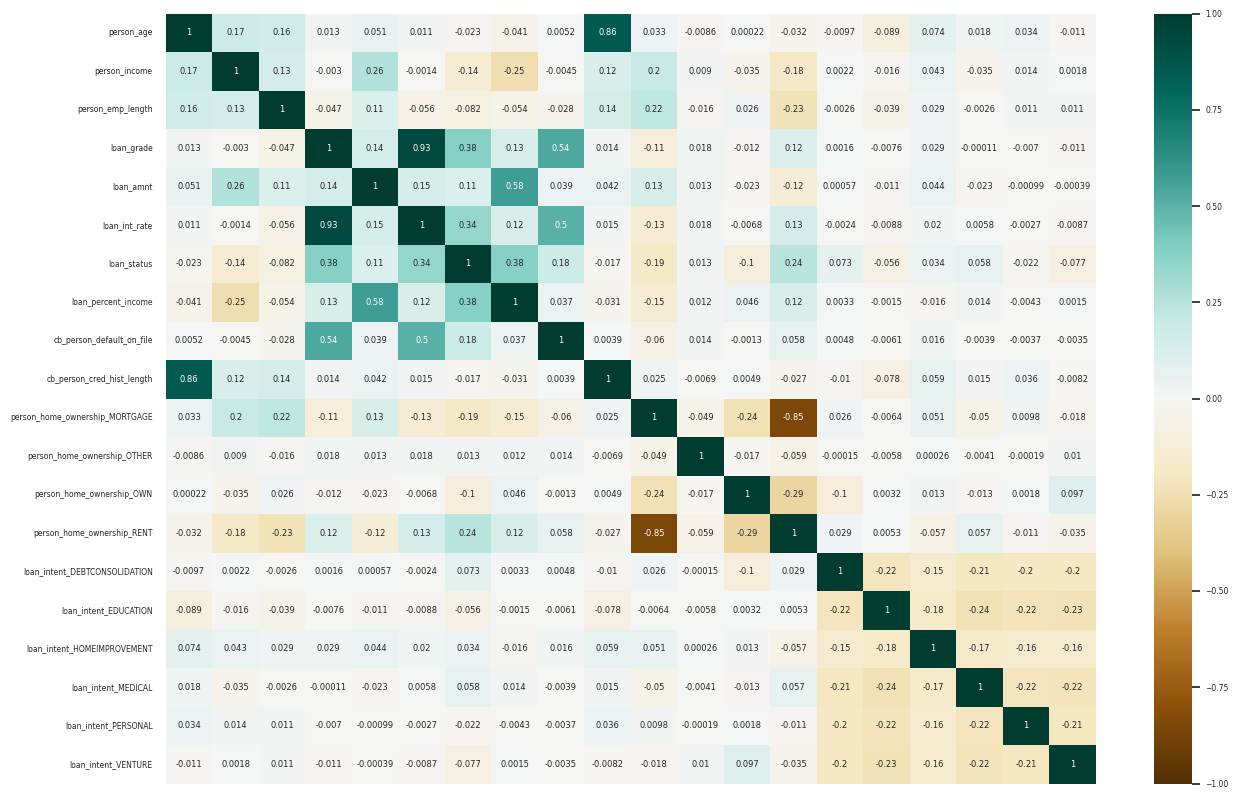

In [10]:
sns.set(rc={'figure.figsize':(15, 10)}, font_scale=.5)
sns.heatmap(data.corr(), annot=True, cmap='BrBG', center=0, vmin=-1, vmax=1, xticklabels=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31686 entries, 0 to 32580
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      31686 non-null  int64  
 1   person_income                   31686 non-null  int64  
 2   person_emp_length               31686 non-null  float64
 3   loan_grade                      31686 non-null  float64
 4   loan_amnt                       31686 non-null  int64  
 5   loan_status                     31686 non-null  int64  
 6   loan_percent_income             31686 non-null  float64
 7   cb_person_default_on_file       31686 non-null  int64  
 8   person_home_ownership_MORTGAGE  31686 non-null  float64
 9   person_home_ownership_OTHER     31686 non-null  float64
 10  person_home_ownership_OWN       31686 non-null  float64
 11  person_home_ownership_RENT      31686 non-null  float64
 12  loan_intent_DEBTCONSOLIDATION   

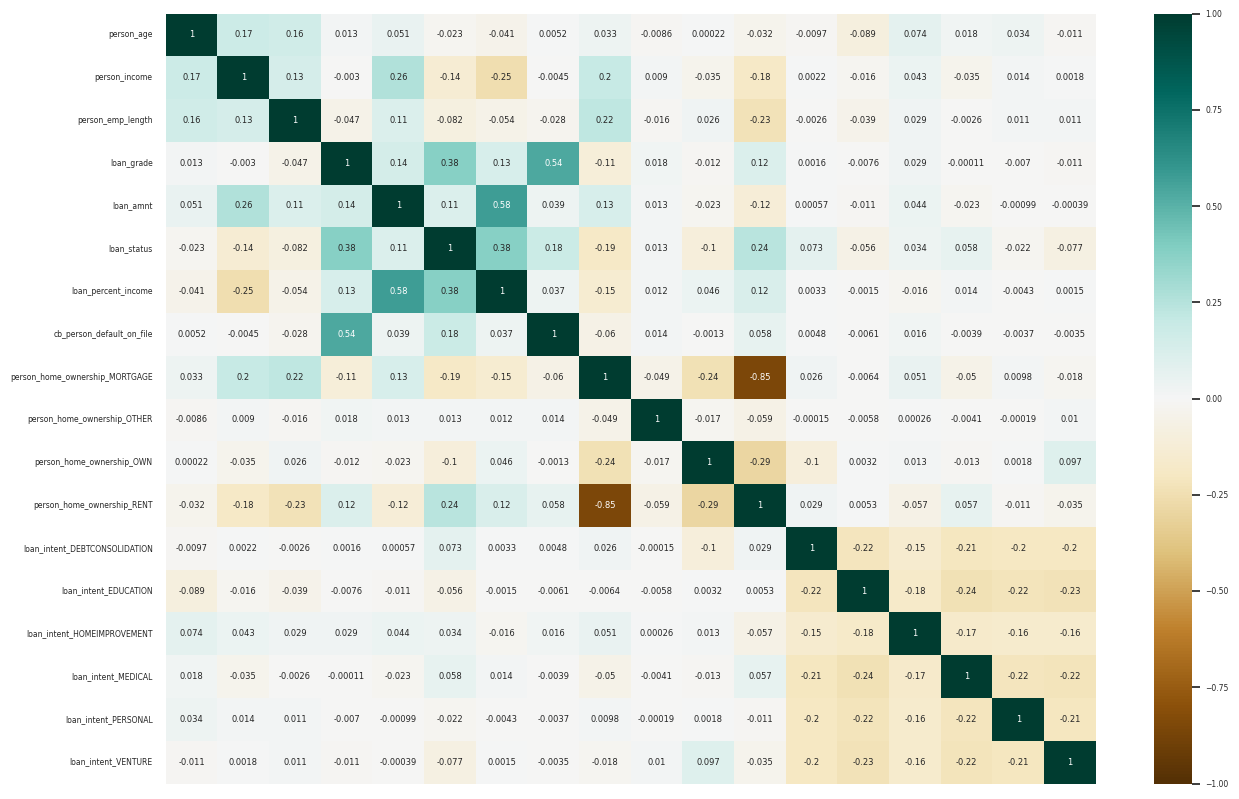

In [11]:
data = data.drop(columns=["cb_person_cred_hist_length", "loan_int_rate"])

sns.heatmap(data.corr(), annot=True, cmap='BrBG', center=0, vmin=-1, vmax=1, xticklabels=False)
data.info()

### Handle Unbalanced Data and Split train/test

<Axes: xlabel='loan_status', ylabel='count'>

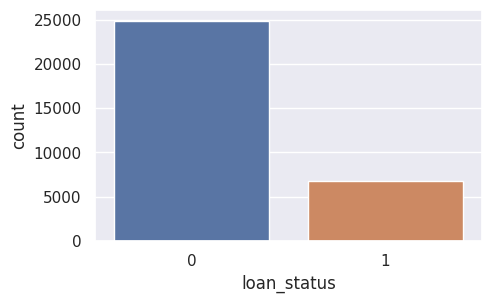

In [12]:
sns.set(rc={'figure.figsize':(5, 3)}, font_scale=1)
sns.countplot(x='loan_status', data=data)

In [13]:
def get_split(data):
  y = data.loc[:, ['loan_status']]
  X = data.loc[:, data.columns != 'loan_status']

  X_train, X_test, y_train, y_test = [x.values for x in train_test_split(X, y, test_size=0.33)]

  # apply SMOTE (oversampling) only to train data
  smote = SMOTE()
  x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

  return x_train_smote, X_test, np.squeeze(y_train_smote), np.squeeze(y_test)

## Train and Evaluate AI Models

In [14]:
def train_evaluate_model(model, data):  
  X_train, X_test, y_train, y_test = get_split(data)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)
  
  cm = confusion_matrix(y_test, y_pred)

  sns.set(rc={'figure.figsize':(3, 3)}, font_scale=1)
  sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

### Gaussian Naive Bayes

Accuracy: 0.43865353351821745


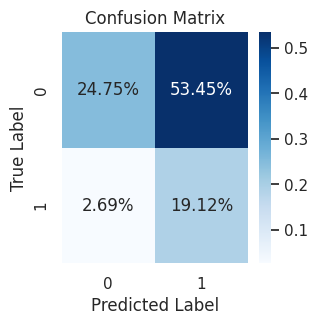

In [15]:
gnb = GaussianNB()
train_evaluate_model(gnb, data)

### Random Forest

Accuracy: 0.9356411972841159


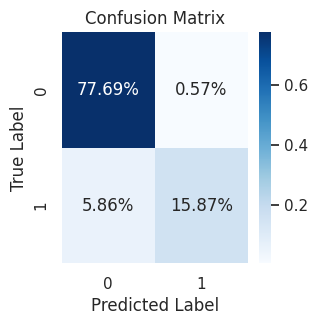

In [16]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=None
)
train_evaluate_model(random_forest, data)

### AdaBoost Tree Ensamble

Accuracy: 0.8869656689299034


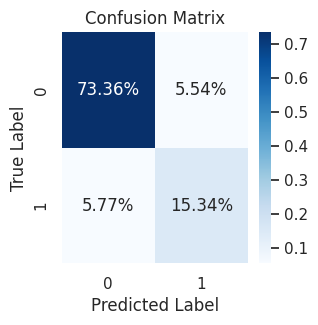

In [17]:
adaboost = AdaBoostClassifier(
    estimator=None, # None == Decisiontree
    n_estimators=50,
    learning_rate=1.0,
)
train_evaluate_model(adaboost, data)

### MLP

Accuracy: 0.22692932963565077


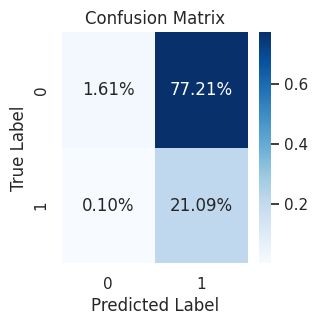

In [18]:
mlp = MLPClassifier(
  hidden_layer_sizes = (50,),
  activation='relu',
  solver='adam',
  alpha=0.0001
)
train_evaluate_model(mlp, data)

### SVM

Accuracy: 0.7447642727359663


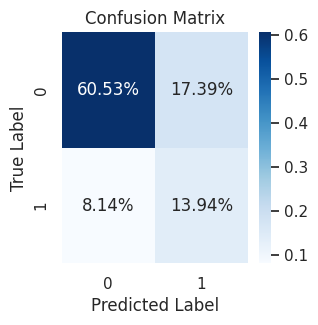

In [19]:
svc = SVC(
  C=1.0,
  kernel='rbf',
)
train_evaluate_model(svc, data)

## Train and Evaluate Logistic Regression

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                33262
Model:                          Logit   Df Residuals:                    33246
Method:                           MLE   Df Model:                           15
Date:                Tue, 23 May 2023   Pseudo R-squ.:                  0.3677
Time:                        06:30:30   Log-Likelihood:                -14578.
converged:                      False   LL-Null:                       -23055.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4863        nan        nan        nan         nan         nan
x1            -0.0067      0.002     -2.682      0.007      -0.012      -0.002
x2          1.562e-06   4.07e-07      3.834      0.0

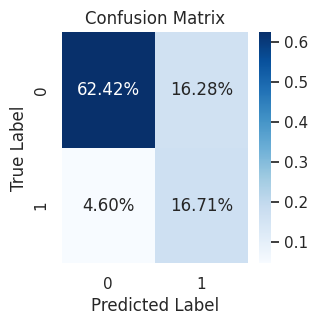

In [20]:
X_train, X_test, y_train, y_test = get_split(data)

X = sm.add_constant(X_train)

model = sm.Logit(y_train, X).fit(disp=False)

print(model.summary())

y_pred_prob = model.predict(sm.add_constant(X_test))

y_pred = (y_pred_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

sns.set(rc={'figure.figsize':(3, 3)}, font_scale=1)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Feature Importance

In [21]:
def plot_feature_importance(feature_importance, model_name):
  importance_values = [imp[0] for imp in feature_importance]
  feature_names = [imp[1] for imp in feature_importance]

  plt.figure(figsize=(10, 6))
  plt.barh(range(len(importance_values)), importance_values, align='center')
  plt.yticks(range(len(feature_names)), feature_names)
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature')
  plt.title(f'Feature Importance for Loan Defaults - {model_name}')
  plt.show()

In [22]:
feature_names = data.loc[:, data.columns != 'loan_status'].columns.tolist()

In [23]:
def get_permutation_importance(model, data):
  _, X_test, _, y_test = get_split(data)

  result = permutation_importance(model, X_test, y_test, n_repeats=5)
  importances = result.importances_mean
  return sorted(zip(importances, feature_names))

### Gaussian Naive Bayes

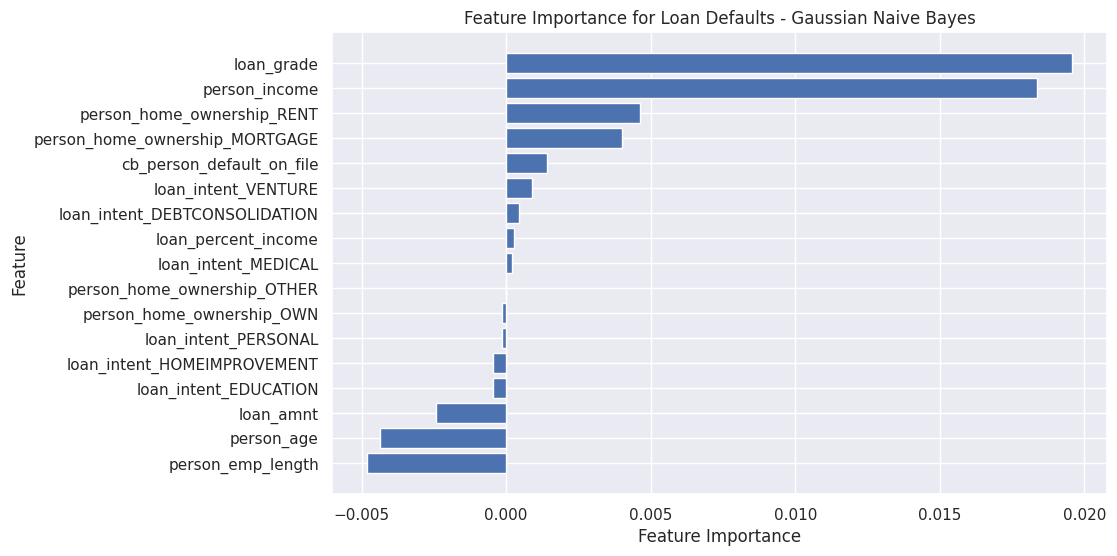

In [24]:
plot_feature_importance(get_permutation_importance(gnb, data), "Gaussian Naive Bayes")

### Random Forest

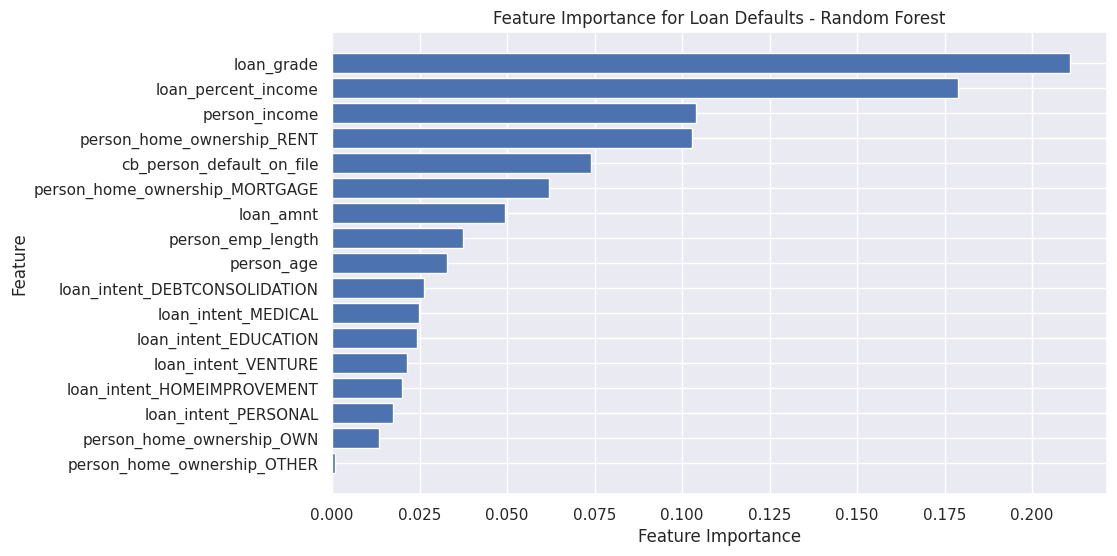

In [25]:
importances = random_forest.feature_importances_

feature_importance = sorted(zip(importances, feature_names))

plot_feature_importance(feature_importance, "Random Forest")

### AdaBoost Tree Ensamble

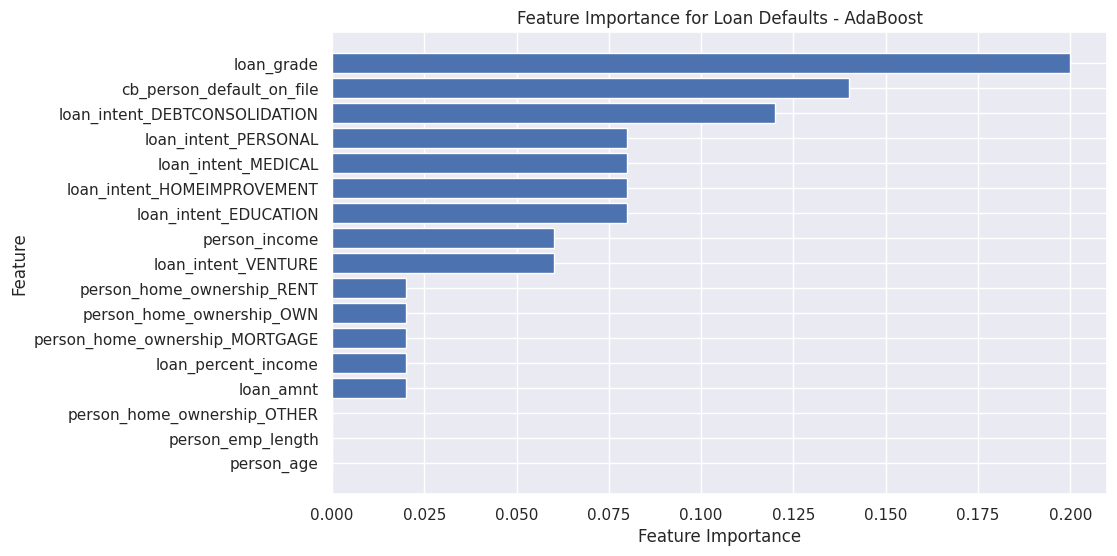

In [26]:
importances = adaboost.feature_importances_

feature_importance = sorted(zip(importances, feature_names))

plot_feature_importance(feature_importance, "AdaBoost")

### MLP

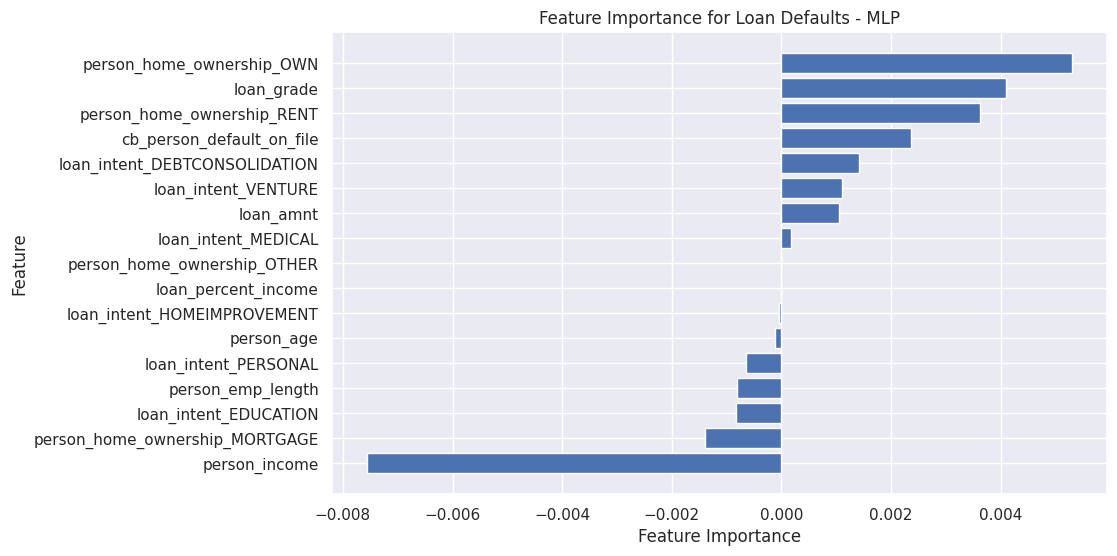

In [27]:
plot_feature_importance(get_permutation_importance(mlp, data), "MLP")

### SVM

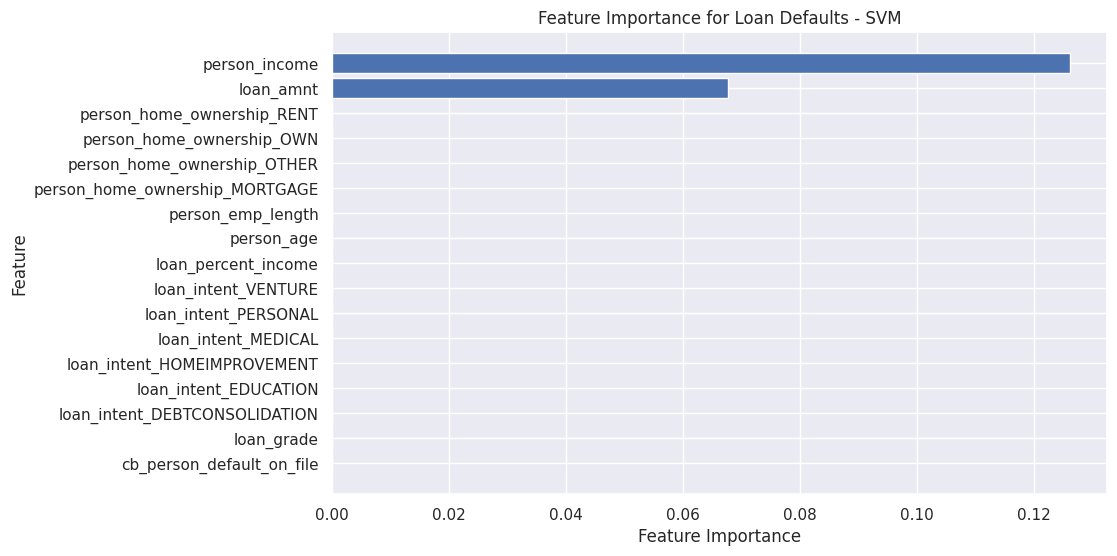

In [28]:
plot_feature_importance(get_permutation_importance(svc, data), "SVM")

## Train Best Model with just the Most Important Features for the webapp demo

In [29]:
clean_data = data[["loan_grade", 
                   "loan_percent_income", 
                   "person_income", 
                   "person_home_ownership_RENT", 
                   "person_home_ownership_MORTGAGE",
                   "person_home_ownership_OWN", 
                   "person_home_ownership_OTHER",
                   "loan_amnt",
                   "cb_person_default_on_file",

                   "loan_status" # output
                   ]]

Accuracy: 0.8815147747920054


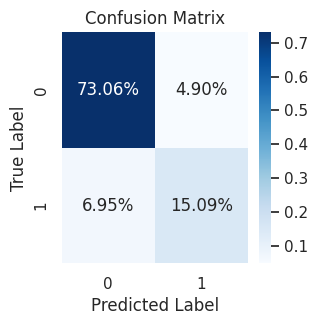

In [30]:
random_forest_best_features = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=None
)
train_evaluate_model(random_forest_best_features, clean_data)

## Save the Best Model

In [31]:
from joblib import dump, load
from datetime import datetime

dump(random_forest_best_features, f"random_forest.joblib")

['random_forest.joblib']

In [33]:
# ! rm /content/drive/MyDrive/ai_finance_projects/prj4/random_forest.joblib
# ! cp random_forest.joblib /content/drive/MyDrive/ai_finance_projects/prj4